# Part 3: Homopolymer eSTRs are associated with low nucleosome occupancy

This notebook contains:

#### Figures:
* **Figure 3A**: Nucleosome occupancy around homopolymers
* **Figure 3B**: DNAseI HS around homopolymers
* **Figure 3C**: DNAseI per-locus around homopolymers
* **Figure 3D**: Homopolymer direction of effect
* **Figure 3E**: Homopolymer strand bias around TS
* **Figure 3F**: Homopolymer direction bias around TSS

#### Supplementary Figures:
* **Supplementary Figure 6**: Homopolymer magnitude of effect around TSS

#### Statistics:


In [1]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-Nuc"
FIGPREFIX = "Figure3"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand"]], on=["gene"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

Populating the interactive namespace from numpy and matplotlib


/home/mgymrek/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: Runtime

In [3]:
# How many causal are polyA/T?
x=(causal[causal["motif"].apply(lambda x: x in ["A","T"])].shape[0])
y=(causal.shape[0])
print(x)
print(y)
print(x/(y*1.0))

# Bias overall in effect direction
b = list(causal[causal["motif"].apply(lambda x: x in ["A","T"])]["beta"].apply(lambda x: int(x>0)))
print(np.mean(b))
print(scipy.stats.binom_test(sum(b), len(b)))

1337
3474
0.384858952216
0.5078534031413613
0.5844151039978582


# Figure 3A/B: nuc/DNAseI HS around STRs in GM12878

Ks_2sampResult(statistic=0.08016322297936129, pvalue=4.472752866373653e-08)


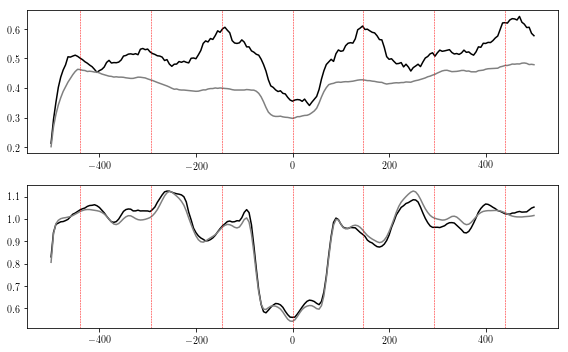

In [11]:
bins = np.arange(-500, 501, 5)
dnasecols = ["dnase-%s"%i for i in bins]
nuccols = ["nuc-%s"%i for i in bins]
cols = ["Gene"] + dnasecols + nuccols

period=1
df = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_causal_%s-wig-ghist.txt"%period, sep="\t")
df_ctrl = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_strs_%s-wig-ghist.txt"%period, sep="\t")
df.columns = cols
df_ctrl.columns = cols

df["dnase.sum"] = df[dnasecols].apply(sum, 1)
df["nuc.sum"] = df[nuccols].apply(sum, 1)
df_ctrl["dnase.sum"] = df_ctrl[dnasecols].apply(sum, 1)

means_dnase = df[dnasecols].apply(np.mean)
means_nuc = df[nuccols].apply(np.mean)
means_dnase_ctrl = df_ctrl[dnasecols].apply(np.mean)
means_nuc_ctrl = df_ctrl[nuccols].apply(np.mean)

# plot dnase/nuc signal aggregate
nucbins = [-147*3, -147*2, -147, 0, 147, 147*2, 147*3]

print(scipy.stats.ks_2samp(df["dnase.sum"], df_ctrl["dnase.sum"]))

fig = plt.figure()
fig.set_size_inches((8,5))
ax = fig.add_subplot(211)


ax.plot(bins, means_dnase, color="black")
ax.plot(bins, means_dnase_ctrl, color="gray")

for nb in nucbins: ax.axvline(nb, color="red", linewidth=0.5, linestyle="dashed")
ax = fig.add_subplot(212)
ax.plot(bins, means_nuc, color="black")
ax.plot(bins, means_nuc_ctrl, color="gray")

for nb in nucbins: ax.axvline(nb, color="red", linewidth=0.5, linestyle="dashed")
fig.tight_layout()

fig.savefig(os.path.join(RESULTSDIR, "%s_DnaseMnaseProfile.pdf"%FIGPREFIX))

# Figure 3C: DNaseI signal heatmap

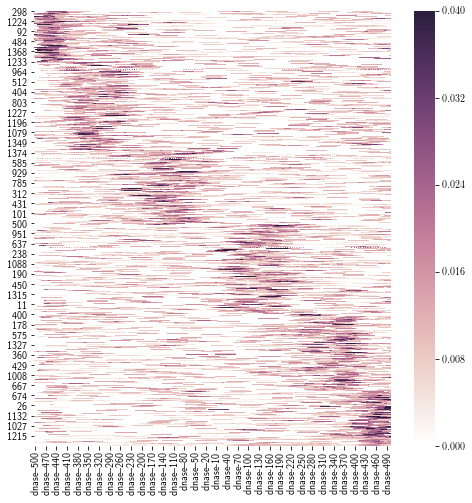

In [13]:
# Heatmaps for nucleosomes

dfx = df[df["dnase.sum"]>0].copy()
# Normalize each row to have same mean
for col in dnasecols:
    normvals = []
    for i in range(dfx.shape[0]):
        normvals.append(dfx[col].values[i]*1.0/dfx["dnase.sum"].values[i])
    dfx[col] = normvals
for col in nuccols:
    normvals = []
    for i in range(dfx.shape[0]):
        normvals.append(dfx[col].values[i]*1.0/dfx["nuc.sum"].values[i])
    dfx[col] = normvals

# Plot heatmap
dfx = dfx[dfx["dnase.sum"]>50]

num_clusters = 6
clusters = KMeans(num_clusters)
clusters.fit(dfx[dnasecols])
dfx["K"] = clusters.labels_

# reorder clusters such that signal goes left to right

k_to_max_bin = {}
for k in range(num_clusters):
    d = dfx[dfx["K"]==k][dnasecols]
    colmeans = list(d.apply(np.mean))
    k_to_max_bin[k] = colmeans.index(max(colmeans))

dfx["K_maxbin"] = dfx.apply(lambda x: k_to_max_bin[x["K"]], 1)
dfx = dfx.sort_values("K_maxbin")
    
cmap = sns.light_palette("black")
fig = plt.figure()
fig.set_size_inches((8,8))
ax = fig.add_subplot(111)
sns.heatmap((dfx[dnasecols]), ax=ax, vmin=0, vmax=0.04, cmap=cmap)
fig.savefig(os.path.join(RESULTSDIR, "%s_DnaseHM.pdf"%FIGPREFIX))

# Figure 3D: Effect size direction poly(dA/dT)

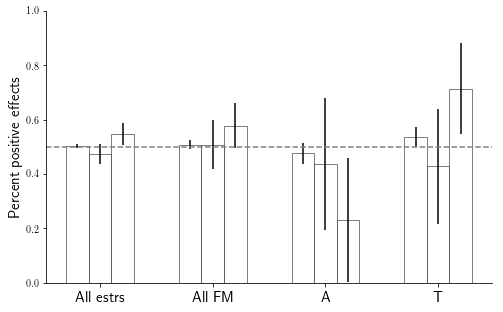

In [14]:
# Effect size bias for homopolymers

labels = []
colors = []
ecolors = []
alphas = []
dirs = []
stderrs = []
nums = []
xvals = []
pvals = []

w = 0.2
udist = 3000
ddist = 3000
tss_bins = [(-10000000, 10000000), (-1*udist, 0), (0, ddist)]
#tss_bins = [(-100000, -50000), (-50000, -10000), (-10000,-3000), (-3000, 0), (0, 3000), (3000,10000), (10000,50000), (50000, 100000)]
binlabels = ["ALL", "promoter", "downstream"]
bincolors = [ "white", "darkgray", "lightgray"]
binalphas = [1, 1, 1]
#binalphas = [1]*len(tss_bins)

def IsARich(x):
    return "A" in x #x.count("A")*1.0/len(x)>0.6

def IsTRich(x):
    return "T" in x # x.count("T")*1.0/len(x)>0.6


polyA = causal[causal["motif"]=="A"]
polyT = causal[causal["motif"]=="T"]
polyAC = causal[(causal["motif"]=="AC")]
polyGT = causal[(causal["motif"]=="GT")]
polyAG = causal[(causal["motif"]=="AG")]
polyCT = causal[(causal["motif"]=="CT")]
polyAT = causal[(causal["motif"]=="AT")]
Arich = causal[(causal["motif"].apply(IsARich))]
Trich = causal[(causal["motif"].apply(IsTRich))]

dfs = [ estrs, causal, polyA, polyT]
classcolors = ["white"]*40
dflabels = ["All estrs", "All FM", "A", "T", ]

ind = 0
for df in dfs:
    dflabel = dflabels[ind]
    for tbin in tss_bins:
        l = "tmp"#binlabels[tss_bins.index(tbin)]
        df_bin = df[(df["dist.tss"]>=tbin[0]) & (df["dist.tss"]<tbin[1])]
        perc = np.mean(df_bin["beta"]>0)
        dirs.append(perc)
        if perc < 1:
            stderrs.append(1.96*np.sqrt(perc*(1-perc)/df_bin.shape[0]))
        elif df_bin.shape[0] == 0: stderrs.append(0)
        else:
            stderrs.append(3/df_bin.shape[0])
        nums.append(df_bin.shape[0])
        pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
    colors.extend([classcolors[ind]]*len(tss_bins))
    alphas.extend(binalphas)
    ind += 1
    xvals.extend([ind+w*i for i in range(len(tss_bins))])
    labels.append(dflabel)
#print(len(alphas))
#print(len(colors))
rgba_colors = np.zeros((len(xvals), 4))
for i in range(len(colors)):
    rgba_colors[i, 0:3] = matplotlib.colors.to_rgba(colors[i])[0:3]
rgba_colors[:, 3] = alphas

fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
ax.bar(xvals, dirs, color=rgba_colors, edgecolor="black", linewidth=0.5, yerr=stderrs, ecolor="black",  width=w)
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_ylim(bottom=0, top=1);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([xvals[i] for i in range(len(xvals)) if i%3 == 1])
ax.set_xticklabels(labels, size=15);
ax.set_ylabel("Percent positive effects", size=15)
fig.savefig(os.path.join(RESULTSDIR, "%s_ATDirection.pdf"%FIGPREFIX))

In [15]:
print("polyT")
print(nums[9:12])
print(dirs[9:12])
print(pvals[9:12])

print("polyA")
print(nums[6:9])
print(dirs[6:9])
print(pvals[6:9])

print("all causal")
print(nums[3:6])
print(dirs[3:6])
print(pvals[3:6])

print("all strs")
print(nums[0:3])
print(dirs[0:3])
print(pvals[0:3])

polyT
[710, 21, 28]
[0.5352112676056338, 0.42857142857142855, 0.7142857142857143]
[0.07767878414059755, 0.6636238098144525, 0.035698138177394874]
polyA
[627, 16, 13]
[0.4768740031897927, 0.4375, 0.23076923076923078]
[0.26346056425865827, 0.8036193847656252, 0.09228515625000003]
all causal
[3474, 118, 140]
[0.5086355785837651, 0.5084745762711864, 0.5785714285714286]
[0.33350752887740354, 0.9267042229477828, 0.07555082875265655]
all strs
[25561, 665, 630]
[0.5034623058565784, 0.47368421052631576, 0.5476190476190477]
[0.2709664693644683, 0.1873078067596973, 0.018671398852210613]


# (removed): A/T distribution around TSS

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0.4176921908365324
0.9999999999999997
0.787706189670044
0.7343420330298466
0.7750029828306241
0.014170490597154388
0.14095628821230857
0.055778327653734326
0.46381761789686893
0.8099490529189239


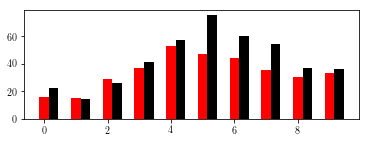

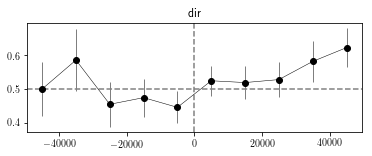

In [16]:
w = 10000
distbins = np.arange(-50000, 50000+w, w)
usecol = "dist.tss"

#w = 100
#distbins = np.arange(-1000, 1000+w, w)
#usecol = "dist.dnase"

nucdata = []
causal["len"] = causal["str.end"]-causal["str.start"]+1

cdata = causal



for xx in [causal[causal["motif"].apply(lambda x: x in ["A"])], causal[causal["motif"].apply(lambda x: x in ["T"])], causal[causal["motif"].apply(lambda x: x in ["A","T"])]]:
    dirs = []
    dirps = []
    direrrs = []
    betas = []
    betaerrs = []
    dists = []
    strands = []
    strandps = []
    stranderrs = []
    lens = []
    lenerrs = []
    dnase = []
    dnaseerrs = []
    nums = []

    for d in range(len(distbins)-1):
        lb = distbins[d]
        ub = distbins[d+1]
        x = xx[(xx[usecol]>=lb) & (xx[usecol]<ub)].copy()
        dird = np.array((x["beta"]>0).apply(int))
        dirs.append(np.mean(dird))
        dirps.append(scipy.stats.binom_test(sum(dird), len(dird)))
        direrrs.append(np.sqrt(np.var(dird)/len(dird)))
        betas.append(np.mean(x["beta"].apply(abs)))
        betaerrs.append(np.sqrt(np.var(x["beta"])/x.shape[0]))
        dists.append(np.mean(x["dist.tss"].apply(abs)))
        s = np.array((x["motif"]=="A").apply(int))
        strands.append(np.mean(s))
        strandps.append(scipy.stats.binom_test(sum(s), len(s)))
        stranderrs.append(np.sqrt(np.var(s)/len(s)))
        lens.append(np.mean(x["len"]))
        lenerrs.append(np.sqrt(np.var(x["len"])/x.shape[0]))
        #dnase.append(np.mean(x["dist.dnase"].apply(abs)))
        #dnaseerrs.append(np.sqrt(np.var(x["dist.dnase"].apply(abs))/x.shape[0]))
        nums.append(x.shape[0])
    nd = pd.DataFrame({"dir": dirs, \
             "dir.p": dirps, \
             "beta": betas, \
             "dist.tss": dists, \
             "strand": strands, \
             "strand.p": strandps, \
                 "dir.err": direrrs, \
                 "beta.err": betaerrs, \
                 "strand.err": stranderrs, \
                      "len": lens, \
                      "len.err": lenerrs, \
                      "num": nums})
    nucdata.append(nd)

siglabels = []
for i in range(len(nucdata[0]["num"])):
    x1 = nucdata[0]["num"][i]
    x2 = nucdata[1]["num"][i]
    print(scipy.stats.binom_test(x1, x1+x2))

fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
ax.bar(range(nucdata[0].shape[0]), list(nucdata[0]["num"]), color="red", width=0.3)
ax.bar([item+0.3 for item in range(nucdata[0].shape[0])], list(nucdata[1]["num"]), color="black", width=0.3)
fig.savefig(os.path.join(RESULTSDIR, "%s_homopolymer_tss_num.pdf"%(FIGPREFIX)))

for col in ["dir"]:     
    fig = plt.figure()
    fig.set_size_inches((6, 2))
    ax = fig.add_subplot(111)
    ax.errorbar(distbins[:-1]+w/2, nucdata[2][col], yerr=nucdata[2]["%s.err"%col], color="black", marker="o", linewidth=0.5)
    if col in [ "dir","strand"]: ax.axhline(y=0.5, linestyle="dashed", color="gray")
    if col == "beta": ax.axhline(y=np.mean(causal["beta"].apply(abs)), color="gray", linestyle="dashed")
    ax.axvline(x=0, linestyle="dashed", color="gray")
    ax.set_title(col)

    fig.savefig(os.path.join(RESULTSDIR, "%s_homopolymer_tss_%s.pdf"%(FIGPREFIX, col)))